# Lower limit magnitude estimate for a saturated star

Forum Topic: https://community.lsst.org/t/deblended-saturated-nearby-stellar-object-artifacts/11374

Melissa Graham

Wed Dec 31 2025

Will run at data.lsst.cloud with Release r29.2.0.

Import packages and instantiate services.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lsst.rsp import get_tap_service
from lsst.daf.butler import Butler
import lsst.geom as geom
import lsst.afw.display as afwDisplay

In [2]:
afwDisplay.setDefaultBackend('matplotlib')
service = get_tap_service("tap")
butler = Butler('dp1', collections="LSSTComCam/DP1")

Nearby (56pc) early M dwarf Gaia EDR3 19636113736531072 has `parentObjectId` 650018973554837957.

In [3]:
parentId = 650018973554837957
star_ra = 37.7439349844
star_dec = 7.6486755702

Query for all children.

In [4]:
query = """SELECT objectId, coord_ra, coord_dec, x, y, r_psfFlux,
        DISTANCE(POINT('ICRS', coord_ra, coord_dec), POINT('ICRS', {}, {})) AS distance
        FROM dp1.Object WHERE parentObjectId = {}""".format(star_ra, star_dec, parentId)
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
assert job.phase == 'COMPLETED'
children = job.fetch_result().to_table()
print(len(children))

24


Display histogram of child distances from Gaia star. There are four that are close enough to be deblended children of the actual star.

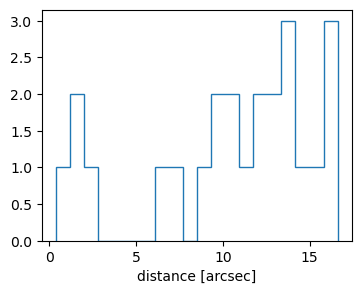

In [5]:
plt.figure(figsize=(4, 3))
plt.hist(3600.0 * children['distance'], bins=20, histtype='step')
plt.xlabel('distance [arcsec]')
plt.show()

Get the overlapping `deep_coadd` image's WCS.

In [6]:
query = "band.name = :band AND patch.region OVERLAPS POINT(:ra, :dec)"
binder = {"band": 'r', "ra": star_ra, "dec": star_dec}
refs = butler.query_datasets("deep_coadd", where=query, bind=binder)
assert len(refs) == 1
wcs = butler.get('deep_coadd.wcs', dataId=refs[0].dataId)

Retrieve a 120 pixel cutout from the `deep_coadd` image.

In [7]:
spoint = geom.SpherePoint(children['coord_ra'][0] * geom.degrees,
                          children['coord_dec'][0] * geom.degrees)
xy = wcs.skyToPixel(spoint)
s = 120 #pixels
xybox = geom.Box2I(minimum=geom.Point2I(xy.getX()-s, xy.getY()-s),
                   maximum=geom.Point2I(xy.getX()+s, xy.getY()+s))
cutout = butler.get("deep_coadd", dataId=refs[0].dataId, parameters={'bbox':xybox})

Get star coordinates in image x,y coordinates.

In [8]:
star_spoint = geom.SpherePoint(star_ra * geom.degrees,
                               star_dec * geom.degrees)
star_xy = wcs.skyToPixel(star_spoint)

Display cutout with Gaia star coordinates marked with a blue star, the four nearest children marked with a yellow circle, and all the other children with red circles.

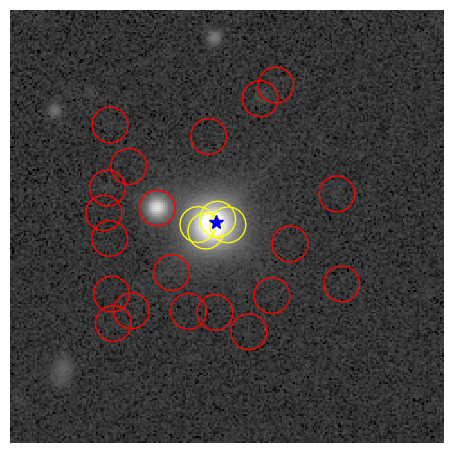

In [9]:
fig = plt.figure(figsize=(6, 6))
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.image(cutout.image)
plt.plot(star_xy.getX(), star_xy.getY(), '*', ms=10, color='blue')
with display.Buffering():
    for ci in range(len(children)):
        color = afwDisplay.RED
        if children['distance'][ci] < 5.0/3600.0:
            color = afwDisplay.YELLOW
        display.dot('o', children['x'][ci], children['y'][ci],
                    size=10, ctype=color)
plt.gca().axis('off')
display.show_colorbar(False)
plt.show()

Sum the fluxes of the four nearest children and convert to a magnitude.
This magnitude is a lower limit, but not a good one, and no uncertainty is possible due to the star being saturated.

In [10]:
tx = np.where(children['distance'] < 5.0/3600.0)[0]
total_flux = float(np.sum(children['r_psfFlux'][tx]))
ll_mag = -2.5 * np.log10(total_flux) + 31.4
print('unreliable lower limit on the star magnitude: r = %6.2f mag' % ll_mag)

unreliable lower limit on the star magnitude: r =  16.45 mag
